In [29]:
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

Found 83791 images.


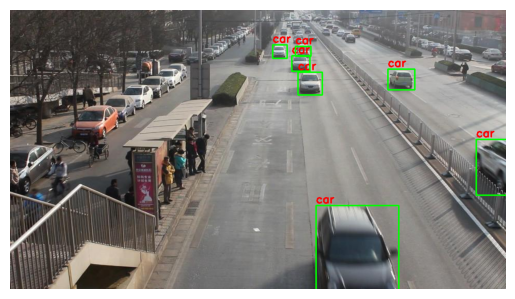

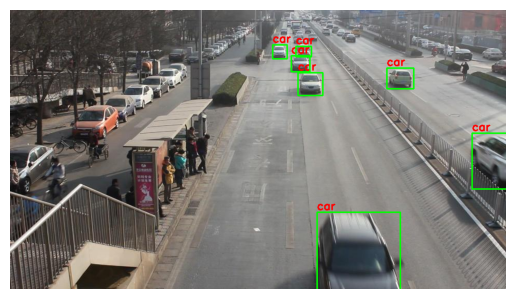

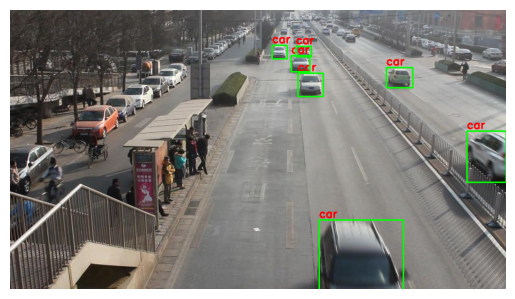

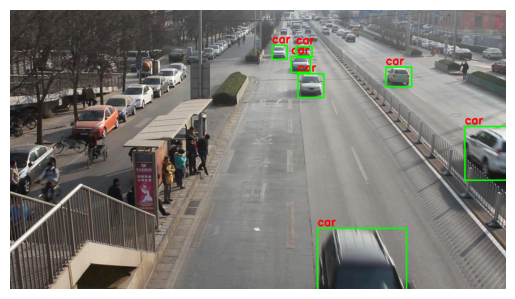

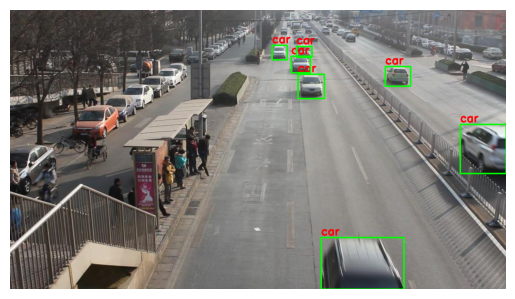

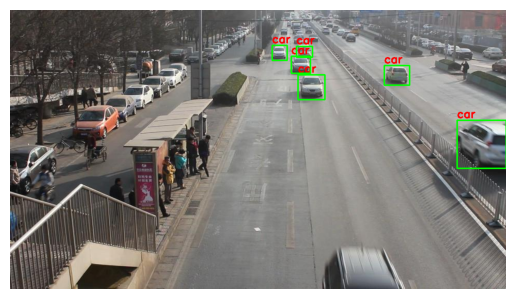

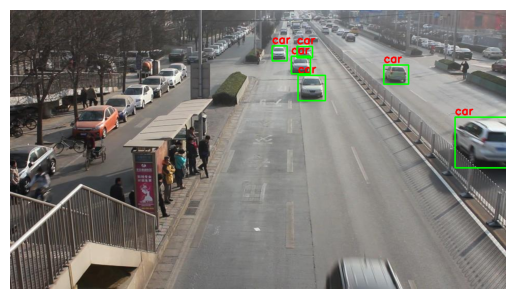

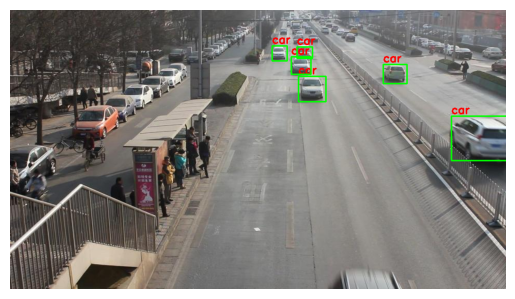

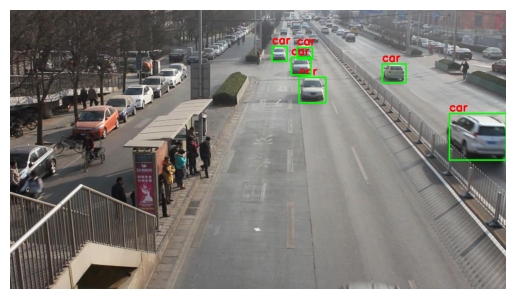

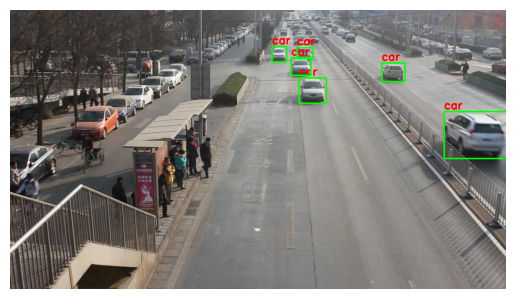

In [ ]:
# paths
IMG_DIR = "/Users/kocak/Desktop/UA-DETRAC/images/train"
LABEL_DIR = "/Users/kocak/Desktop/UA-DETRAC/labels/train"
CLASS_NAMES = ["0",'car', 'bus', 'van', 'others']

img_files = sorted([f for f in os.listdir(IMG_DIR) if f.endswith('.jpg') or f.endswith('.png')])
print(f"Found {len(img_files)} images.")


def read_yolo_label(label_path):
    with open(label_path, "r") as f:
        labels = [line.strip().split() for line in f]
    return labels

def plot_img_with_boxes(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    labels = read_yolo_label(label_path)
    for label in labels:
        class_id = int(label[0])
        x_center, y_center, bw, bh = map(float, label[1:])
        x1 = int((x_center - bw/2) * w)
        y1 = int((y_center - bh/2) * h)
        x2 = int((x_center + bw/2) * w)
        y2 = int((y_center + bh/2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, CLASS_NAMES[class_id], (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# List and sort files (to get consistent first 100)
img_files = sorted([f for f in os.listdir(IMG_DIR) if f.endswith('.jpg') or f.endswith('.png')])
for img_file in img_files[:10]:
    label_file = img_file.rsplit('.', 1)[0] + '.txt'  # assumes same base name
    img_path = os.path.join(IMG_DIR, img_file)
    label_path = os.path.join(LABEL_DIR, label_file)
    if os.path.exists(label_path):  # skip if label is missing
        plot_img_with_boxes(img_path, label_path)

In [35]:
class YOLODataset(Dataset):
    def __init__(self, img_dir, label_dir, class_names, transforms=None, max_samples=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.class_names = class_names
        self.transforms = transforms
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
        if max_samples:
            self.img_files = self.img_files[:max_samples]
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        label_file = img_file.rsplit('.', 1)[0] + '.txt'
        img_path = os.path.join(self.img_dir, img_file)
        label_path = os.path.join(self.label_dir, label_file)

        # Görseli oku
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Label dosyasını oku ve bbox'ları convert et
        boxes = []
        labels = []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    class_id, x_c, y_c, bw, bh = map(float, line.strip().split())
                    x_c *= w
                    y_c *= h
                    bw *= w
                    bh *= h
                    # [xmin, ymin, xmax, ymax]
                    xmin = x_c - bw/2
                    ymin = y_c - bh/2
                    xmax = x_c + bw/2
                    ymax = y_c + bh/2
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(int(class_id)+1)  # class_id+1, çünkü PyTorch'ta 0 arka plan!

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        if self.transforms:
            img = self.transforms(img)

        img = torch.as_tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0

        return img, target

# Kullanım:
IMG_DIR = "/Users/kocak/Desktop/UA-DETRAC/images/train_100"
LABEL_DIR = "/Users/kocak/Desktop/UA-DETRAC/labels/train_100"
CLASS_NAMES = ['others','car', 'bus', 'van']

dataset = YOLODataset(IMG_DIR, LABEL_DIR, CLASS_NAMES, max_samples=100)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Modeli yükle, son katmanı sınıf sayısına göre değiştir
num_classes = 1 + len(CLASS_NAMES)  # 1 arka plan + sınıflar
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Dataloader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0005)

# Eğitim döngüsü (kısa ve basit)
model.train()
for epoch in range(2):  # küçük veri için epoch artırılabilir
    for imgs, targets in dataloader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Model kaydetme
torch.save(model.state_dict(), "fasterrcnn_vehicle.pth")

KeyboardInterrupt: 

In [39]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device: CUDA, Apple MPS, else CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

class VehicleDataset(Dataset):
    def __init__(self, img_dir, label_dir, class_names, transforms=None, max_samples=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.class_names = class_names
        self.transforms = transforms
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
        if max_samples:
            self.img_files = self.img_files[:max_samples]
    
    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        label_file = img_file.rsplit('.', 1)[0] + '.txt'
        img_path = os.path.join(self.img_dir, img_file)
        label_path = os.path.join(self.label_dir, label_file)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        boxes, labels = [], []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    class_id, x_c, y_c, bw, bh = map(float, line.strip().split())
                    x_c, y_c, bw, bh = x_c * w, y_c * h, bw * w, bh * h
                    xmin = x_c - bw / 2
                    ymin = y_c - bh / 2
                    xmax = x_c + bw / 2
                    ymax = y_c + bh / 2
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(int(class_id) + 1)  # PyTorch: background = 0

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        if self.transforms:
            img = self.transforms(img)

        img = torch.as_tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0

        return img, target
    
# Update these paths for your dataset
TRAIN_IMG = "/Users/kocak/Desktop/UA-DETRAC/images/train_100"
TRAIN_LBL = "/Users/kocak/Desktop/UA-DETRAC/labels/train_100"
VAL_IMG = "/Users/kocak/Desktop/UA-DETRAC/images/val_20"
VAL_LBL = "/Users/kocak/Desktop/UA-DETRAC/labels/val_20"
CLASSES = ['car', 'bus', 'truck', 'motorbike']

train_dataset = VehicleDataset(TRAIN_IMG, TRAIN_LBL, CLASSES, max_samples=100)
val_dataset   = VehicleDataset(VAL_IMG,   VAL_LBL,   CLASSES, max_samples=20)

def collate_fn(batch):  # for DataLoader
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=0)

num_classes = 1 + len(CLASSES)  # background + classes
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 10

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Train loss: {avg_train_loss:.4f}")

    # Validation loop (optional)
    model.eval()
    val_total_loss = 0
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(imgs, targets)
            val_loss = sum(loss for loss in loss_dict.values())
            val_total_loss += val_loss.item()
    avg_val_loss = val_total_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Val loss: {avg_val_loss:.4f}")

torch.save(model.state_dict(), "fasterrcnn_vehicle.pth")
print("Model saved as 'fasterrcnn_vehicle.pth'")

model.eval()
import random
img, target = val_dataset[random.randint(0, len(val_dataset)-1)]
with torch.no_grad():
    prediction = model([img.to(device)])[0]

plt.figure(figsize=(8, 8))
img_np = img.permute(1, 2, 0).cpu().numpy()
plt.imshow(img_np)
for box, label in zip(prediction['boxes'].cpu(), prediction['labels'].cpu()):
    xmin, ymin, xmax, ymax = map(int, box)
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='red', linewidth=2))
    plt.text(xmin, ymin-5, CLASSES[label-1], color='yellow', fontsize=12)
plt.axis('off')
plt.show()

Using device: mps


/Users/kocak/Library/Python/3.9/lib/python/site-packages/torch/autograd/graph.py:824: UserWarning: roi_align_backward_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/Context.cpp:97.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/10:   2%|▏         | 1/50 [06:03<4:57:09, 363.86s/it]


KeyboardInterrupt: 

### YOLO

In [25]:

def add_random_occlusion(img, max_occ_size=0.3):
    h, w, _ = img.shape
    occ_w = int(np.random.uniform(0.1, max_occ_size) * w)
    occ_h = int(np.random.uniform(0.1, max_occ_size) * h)
    x1 = np.random.randint(0, w - occ_w)
    y1 = np.random.randint(0, h - occ_h)
    img[y1:y1+occ_h, x1:x1+occ_w] = np.random.randint(0, 255, (occ_h, occ_w, 3), dtype=np.uint8)
    return img

def augment_and_resize(img_path, size=640):
    img = cv2.imread(img_path)
    # Random occlusion
    if np.random.rand() < 0.3:
        img = add_random_occlusion(img)
    # Add random noise
    if np.random.rand() < 0.3:
        noise = np.random.normal(0, 15, img.shape).astype(np.uint8)
        img = cv2.add(img, noise)
    # Resize
    img = cv2.resize(img, (size, size))
    return img

In [ ]:
""" # Kaynak yollar
IMG_SRC = "/Users/kocak/Desktop/UA-DETRAC/images/train"
LBL_SRC = "/Users/kocak/Desktop/UA-DETRAC/labels/train"

# Hedef yollar
IMG_DST_TRAIN = "/Users/kocak/Desktop/UA-DETRAC/images/train_300"
LBL_DST_TRAIN = "/Users/kocak/Desktop/UA-DETRAC/labels/train_300"
IMG_DST_VAL = "/Users/kocak/Desktop/UA-DETRAC/images/val_60"
LBL_DST_VAL = "/Users/kocak/Desktop/UA-DETRAC/labels/val_60"

# Hedef klasörleri oluştur
os.makedirs(IMG_DST_TRAIN, exist_ok=True)
os.makedirs(LBL_DST_TRAIN, exist_ok=True)
os.makedirs(IMG_DST_VAL, exist_ok=True)
os.makedirs(LBL_DST_VAL, exist_ok=True)

# Tüm görsel dosyalarını sırala
img_files = sorted([f for f in os.listdir(IMG_SRC) if f.endswith(".jpg") or f.endswith(".png")])

# İlk 100'ü train, ilk 20'yi val olarak ayır
train_imgs = img_files[:300]
val_imgs = img_files[:60]

# Train dosyalarını kopyala
for img_file in train_imgs:
    shutil.copy(os.path.join(IMG_SRC, img_file), os.path.join(IMG_DST_TRAIN, img_file))
    label_file = img_file.rsplit('.', 1)[0] + '.txt'
    if os.path.exists(os.path.join(LBL_SRC, label_file)):
        shutil.copy(os.path.join(LBL_SRC, label_file), os.path.join(LBL_DST_TRAIN, label_file))

# Val dosyalarını kopyala
for img_file in val_imgs:
    shutil.copy(os.path.join(IMG_SRC, img_file), os.path.join(IMG_DST_VAL, img_file))
    label_file = img_file.rsplit('.', 1)[0] + '.txt'
    if os.path.exists(os.path.join(LBL_SRC, label_file)):
        shutil.copy(os.path.join(LBL_SRC, label_file), os.path.join(LBL_DST_VAL, label_file)) """

In [ ]:
from ultralytics import YOLO

# model
model = YOLO('yolov8n.pt')

# staring train
results = model.train(
    data='/Users/kocak/Desktop/UA-DETRAC/data.yaml',
    epochs=3,
    imgsz=640,
    batch=8,
    project='runs',
    name='yolov8_vehicle',
    workers=2
)

Ultralytics 8.3.134 🚀 Python-3.9.6 torch-2.7.0 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/kocak/Desktop/UA-DETRAC/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_vehicle, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretraine

train: Scanning /Users/kocak/Desktop/UA-DETRAC/labels/train_300.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3284.1±480.7 MB/s, size: 79.2 KB)



val: Scanning /Users/kocak/Desktop/UA-DETRAC/labels/val_60.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]

Plotting labels to runs/yolov8_vehicle/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/yolov8_vehicle
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3         0G      1.375      4.051      1.004        106        640:  13%|█▎        | 5/38 [00:08<00:55,  1.68s/it]


KeyboardInterrupt: 